In [80]:
import MDAnalysis as mda
from MDAnalysis.lib import distances
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.fft import fft, fftfreq

strc_file = '/media/bhehlen/Expansion/CD16_newDyna/nofuc1/MULTIDIR/2/merged_files/step3_input_no_water_no_ions.pdb'
traj_file = '/media/bhehlen/Expansion/CD16_newDyna/nofuc1/MULTIDIR/2/merged_files/all_aligned_no_water_no_ions.xtc'
#strc_file = '/media/bhehlen/Expansion/CD16_newDyna/3ay4/multidir/2/merged_files/step3_input_no_water_no_ions.pdb'
#traj_file = '/media/bhehlen/Expansion/CD16_newDyna/3ay4/multidir/2/merged_files/all_aligned_no_water_no_ions.xtc'


# Load your trajectory and topology files
u = mda.Universe(strc_file, traj_file)

# Print the unique segids and residue names to identify sugars
unique_segids = set(atom.segid for atom in u.atoms)
unique_residues = set(atom.resname for atom in u.atoms)
print("Unique SegIDs:", unique_segids)
print("Unique Residues:", unique_residues)

Unique SegIDs: {'CARC', 'PROC', 'CARD', 'CARB', 'CARA', 'PROB', 'PROA'}
Unique Residues: {'TYR', 'ALA', 'BGAL', 'SER', 'LYS', 'CYS', 'THR', 'AMAN', 'BMAN', 'LEU', 'GLY', 'ASN', 'HIS', 'GLU', 'ARG', 'MET', 'PHE', 'ASP', 'VAL', 'GLN', 'BGLC', 'AFUC', 'PRO', 'TRP', 'ILE'}


Distance between centers of mass running ..... 
done
Average over all traj. : 8.635496664154106
Distances between centers of mass saved in distance.dat
Autocorrelation function & FFT running ...


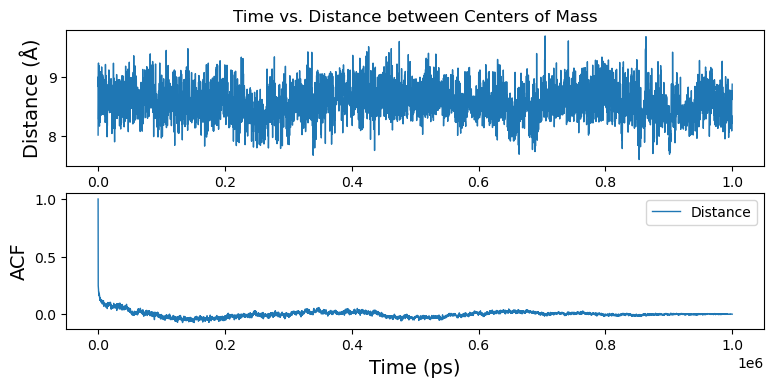

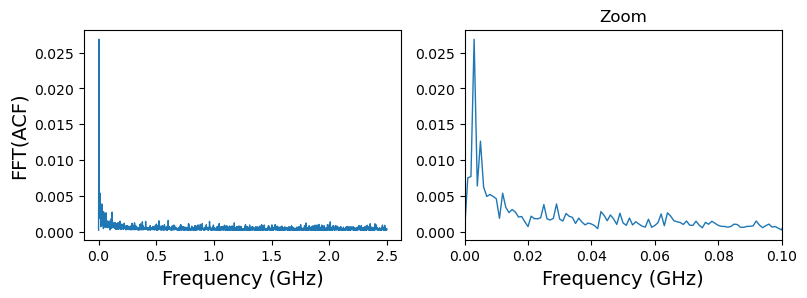

In [82]:

# Define two atom selections
#selection1 = u.select_atoms("segid CARA and resnum 1 and name O6")
#selection1 = u.select_atoms("segid CARB and resnum 1")
selection1 = u.select_atoms("segid PROA and resname ASP and resid 239")
#selection1 = u.select_atoms("segid PROA")


#selection2 = u.select_atoms("segid CARC and resnum 4 and name HO6")
#selection2 = u.select_atoms("segid CARC and resnum 4")
selection2 = u.select_atoms("segid PROC and resname LYS and resid 138")
#selection2 = u.select_atoms("segid PROC")

print('Distance between centers of mass running ..... ')

# Calculate the center of mass for each frame  (or type 'compound='residues')
com_selection1 = np.array([selection1.center_of_mass(compound='group') for ts in u.trajectory])
com_selection2 = np.array([selection2.center_of_mass(compound='group') for ts in u.trajectory])

#print(np.shape(com_selection1))

# Reshape the arrays for the distance calculation
com_selection1_reshaped = com_selection1.reshape((len(com_selection1), 3))
com_selection2_reshaped = com_selection2.reshape((len(com_selection2), 3))


# Calculate distances between centers of mass for each frame
distances_array = mda.lib.distances.distance_array(com_selection1_reshaped, com_selection2_reshaped, \
                                                   box=u.dimensions)

# Calculate the distnace between the two selected elements
distances=np.diag(distances_array)
print("done")
# Print the average distances
average_distances = np.mean(distances_array, axis=1)
print("Average over all traj. :",np.mean(average_distances))
print("Distances between centers of mass saved in \033[1mdistance.dat\033[0m")
time_values = [ts.time for ts in u.trajectory]
np.savetxt('data/distance.dat', distances)

#################" ACF Calculation
print('Autocorrelation function & FFT running ...')
# distance.dat obtained by distance_analysis.ipynb
fname='data/distance.dat'   
dat=np.loadtxt(fname, delimiter=' ', dtype = float)
yraw=dat[:]
N=len(yraw)
time=[ts.time for ts in u.trajectory]
#xraw=np.linspace(0,N,N) 
dt=0.2                    #time step in ns
    
# Calculate ACF
yac = sm.tsa.acf(yraw, nlags=2*N-1)
xacf=fftfreq(N,dt)[:N//2]
yacf=fft(yac)

#plot
# Create a figure for all XY plots
plt.figure(figsize=(9, 6))

label="Distance"
plt.subplot(3,1,1)
plt.plot(time, yraw, marker='', linestyle='-', label=label, linewidth=1)
plt.title("Time vs. Distance between Centers of Mass")
plt.ylabel("Distance (Å)", fontsize=14)
plt.subplot(3,1,2)
plt.plot(time, yac, marker='', linestyle='-', label=label,  linewidth=1)
plt.ylabel("ACF", fontsize=14)
plt.xlabel("Time (ps)", fontsize=14)
plt.legend()
plt.show()

plt.figure(figsize=(9, 6))
plt.subplot(2,2,2)
plt.plot(xacf,2.0/N * np.abs(yacf[0:N//2]), marker='', linestyle='-', label=label, linewidth=1)
plt.xlabel("Frequency (GHz)", fontsize=14)
plt.xlim(0,0.1)
plt.title("Zoom")
plt.subplot(2,2,1)
plt.plot(xacf,2.0/N * np.abs(yacf[0:N//2]), marker='', linestyle='-', label=label, linewidth=1)
plt.xlabel("Frequency (GHz)", fontsize=14)
plt.ylabel("FFT(ACF)", fontsize=14)
plt.show()    
    
#save data
#ac = np.column_stack((xac*dt, yac))       #Autocorrelation function
#acf= np.column_stack((xac*dt, yacf))     # FFT(ACF)


# Plot the distances as a function of time
#time_values = [ts.time for ts in u.trajectory]

#plt.plot(time_values, distances, label="Distance")
#plt.xlabel("Time (ps)")
#plt.ylabel("Distance (Å)")
#plt.title("Time vs. Distance between Centers of Mass")
#plt.legend()
#plt.show()
